## MRI preprocessing
The goal of this Notebook is to **preprocess all the Magnetic Resonance Images (MRI)**. These MRIs are in a zipped NIfTI format (.nii.gz), after having carried out the Notebook ***1_Capture_data***, where the NIfTI files have been reorganized, zipped and placed all together in the **folder 'Datasets/Extracted_files'**.

NIfTI (Neuroimaging Informatics Technology Initiative) files are used to storage MRI images. A NIfTI file includes the data of the 3D image, and information about the coordinate system and other metadata. More information about NIfTI files can be found [here](https://docs.safe.com/fme/html/FME_Desktop_Documentation/FME_ReadersWriters/nifti/nifti.htm). Library [Nibabel](https://nipy.org/nibabel/gettingstarted.html) is used in Python to work with NIfTI files.

The preprocessing stage includes the following steps:
   - Read NIfTI: extract image data from the file.
   - Remove skull from the 3D image of the brain.
   - Normalize pixel intensity of the 3D image.
   - Resize the 3D image.
   - Save the 3D image as a numpy’s compressed format (.npz).

This notebook is structured as follows:
   - Import libraries
   - Define functions
   - NIfTI overview
   - Skull stripping overview
   - NIfTI files selection
   - NIfTI preprocessing

### Initial set-up

#### Google Colab

In [1]:
# Specify if user is working on Google Drive
google_colab = False

In [2]:
if google_colab == True:
    
    from google.colab import drive 
    drive.mount('/content/drive')
    
    path = './drive/MyDrive/TFM/Code/'
    
    import os
    os.chdir(path)

else:
    path = '../'
    
    import os
    os.chdir(path)

### Import libraries

In [3]:
import os
import time
import copy
import random
import numpy as np
import pandas as pd
import nibabel as nib
from scipy import ndimage
from Notebooks.aux_functions.aux_functions_visualization import *
from Notebooks.aux_functions.deepbrain_package.extractor import Extractor

### Define functions

In [7]:
def read_nifti_file(file):
    '''
    Function used to load and read a NIfTI file
    Inputs: NIfTI file directory
    Output: NIfTI image data
    ''' 
    
    # Load NIfTI file
    volume = nib.load(file)
    
    # Read image data from NIfTI file
    volume = volume.get_fdata()
        
    return volume


def remove_skull(volume):
    '''
    Function used to remove skull from brain image
    Inputs: MRI image
    Output: brain image without skull
    ''' 
    
    # Initialize brain mass extractor
    ext = Extractor()

    # Calculate probability of being brain mass
    prob = ext.run(volume) 

    # Extract mask with probability higher than 50% of being brain mass
    mask = prob > 0.5
    
    # Detect mask from image
    volume [mask == False] = 0
    volume = volume.astype('float32')
    
    return volume


def resize_volume(volume):
    '''
    Function used to resize the brain image
    Input: brain image
    Output: brain image resized
    '''
    
    # Exchange axis 0 and 2
    if volume.shape[1] == volume.shape[2]:
        volume = np.swapaxes(volume, 0, 2)

    # Cut volume
    if volume.shape[0] == 256:
        volume = volume[20:210, 40:240, 20:140]

    if volume.shape[0] == 192:
        volume = volume[25:175, 30:180,15:155]
    
    # Define desired shape
    input_shape = (110,130,80)
    
    # Compute factors
    height = volume.shape[0] / input_shape[0]
    width = volume.shape[1] / input_shape[1]
    depth = volume.shape[2] / input_shape[2]

    height_factor = 1 / height
    width_factor = 1 / width
    depth_factor = 1 / depth
    
    # Resize image
    volume_new = ndimage.zoom(volume, (height_factor, width_factor, depth_factor), order=1)
        
    return volume_new


def normalize(volume):
    '''
    Function used to normalize the image pixel intensity
    Input: brain image
    Output: brain image normalized
    '''
    
    I_min = np.amin(volume)
    I_max = np.amax(volume)
    new_min = 0.0
    new_max = 1.0
    
    volume_nor = (volume - I_min) * (new_max - new_min)/(I_max - I_min)  + new_min
    volume_nor = volume_nor.astype('float32')
    
    return volume_nor


def save_matrix(volume, file, save_path = './Datasets/Image_files/'):
    '''
    Function used to save brain image matrix into numpy’s compressed format (.npz)
    Input: processed brain image, original NIfTI file, directory where to save the numpy file
    Output: processed brain image saved as numpy’s compressed format (.npz)
    '''
    
    # Check if save_path folder exists
    if not os.path.exists(save_path):
        os.mkdir(save_path)   

    # Get Image ID from path
    title = file.split('_')[-1].split('.')[0]
    
    # Save volume array
    if os.path.exists(save_path + title + '.npz'):
        print(f'    {title} was already processed.')
    else:
        np.savez_compressed(save_path + title, volume)
    

def process_scan(file, save_path):
    '''
    Function used to process a NIfTI file (read, remove skull, resize, normalize and save it as numpy file)
    Input: NIfTI file directory
    Output: directory where to save the NIfTI file processed as numpy’s compressed format (.npz)
    '''
    
    # Read Nifti file
    volume = read_nifti_file(file)
    
    # Remove skull from image
    volume = remove_skull(volume)
    
    # Resize 3D image
    volume = resize_volume(volume)
    
    # Normalize pixel intensity
    volume = normalize(volume)
    
    # Save 3D matrix
    save_matrix(volume, file, save_path)
    
    return volume

### NIfTI overview

In [20]:
# Specify NIfTI file directory to analyze
file = './Datasets/test.nii'

In [21]:
# Read NIfTI file using nibabel library
volume = nib.load(file)

In [22]:
# Check type of file
print(type(volume))

<class 'nibabel.nifti1.Nifti1Image'>


In [23]:
# Check header of the file
print(volume.header)      

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 124   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.      0.9375  0.9375  1.5     0.0143  1.      1.      1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.70710677
quatern_d       : 0.70710677
qoffset_x       : 120.0
qoffset_y       : 89.2
qoffset_z       : -1

In [24]:
# Check shape of the file
print(volume.shape)

(256, 256, 124)


In [25]:
# Check data type of the file
print(volume.get_data_dtype())

int16


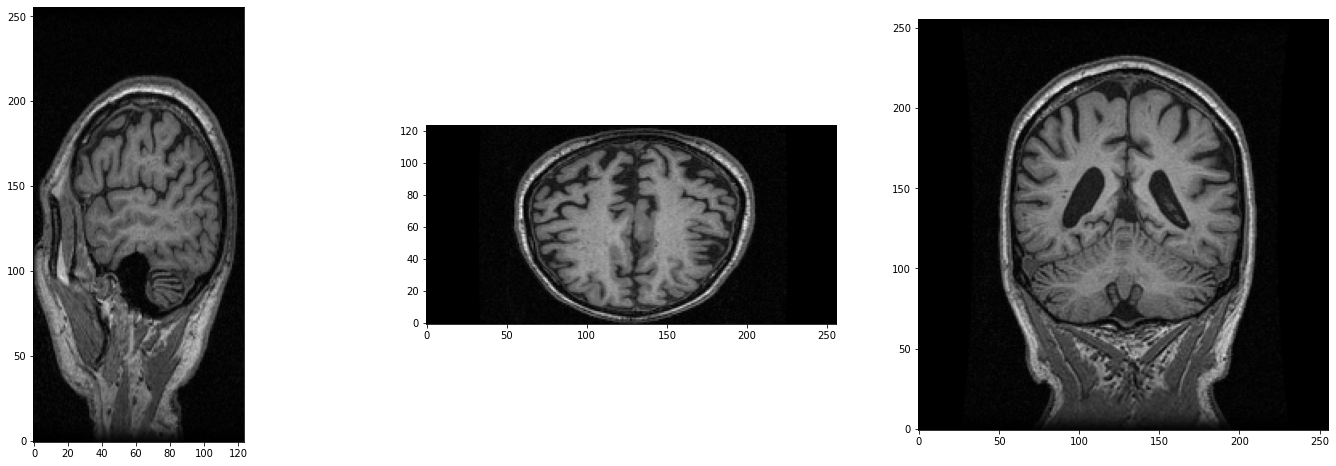

In [26]:
# Visualize slices of the 3D image
volume_data = volume.get_fdata()
neuro_plot(volume_data, view_ = 'all', slice_ = [180, 180, 80])

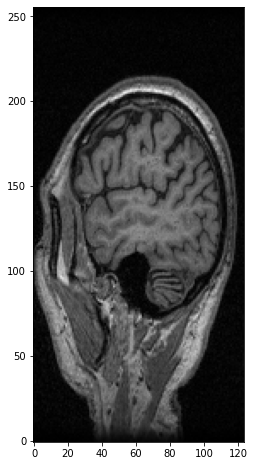

In [27]:
# Visualize first view of the image
neuro_plot(volume_data, view_ = 'first', slice_ = 180)

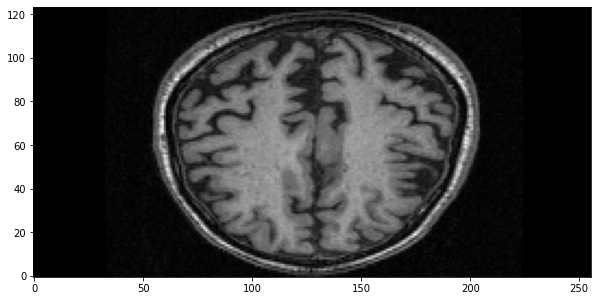

In [28]:
# Visualize second view of the image
neuro_plot(volume_data, view_ = 'second', slice_ = 180)

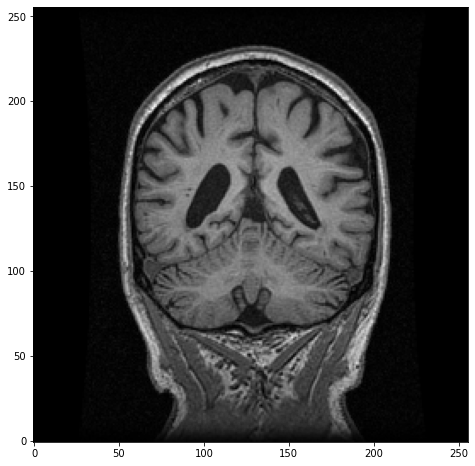

In [29]:
# Visualize third view of the image
neuro_plot(volume_data, view_ = 'third', slice_ = 80)

### Skull-stripping overview

In [32]:
# Specify NIfTI file directory to analyze
file = './Datasets/test.nii'

In [33]:
# Load NIfTI file and read image data
volume = read_nifti_file(file)

In [34]:
# Initialize brain mass extractor
ext = Extractor()

Instructions for updating:
Use tf.gfile.GFile.


In [35]:
# Calculate probability of being brain mass
prob = ext.run(volume) 

In [36]:
# Extract mask with probability higher than 50% of being brain mass
mask = prob > 0.5

In [37]:
# Detect only pixels with brain mass
volume_cleaned = copy.copy(volume)
volume_cleaned [mask == False] = 0

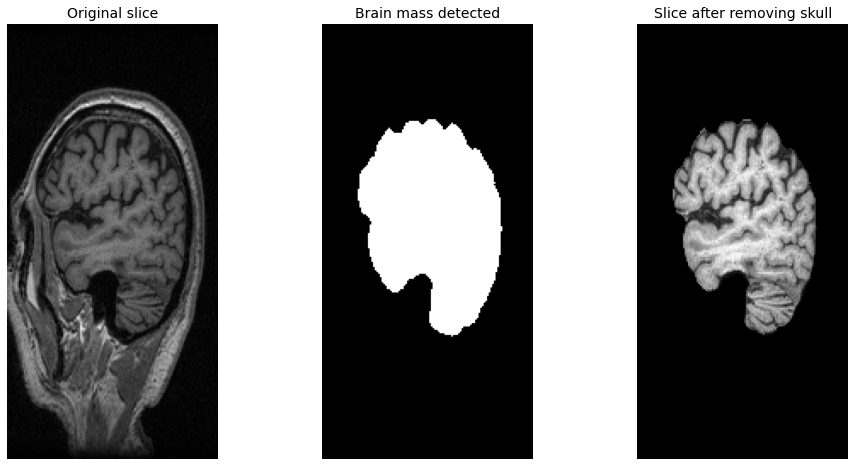

In [38]:
# Plot original slice, brain mass detected and slice with skull removed
fig, axes = plt.subplots(1, 3, figsize=(16,8), sharey=True)
        
axes[0].imshow(volume[80, :, :], cmap = 'gray', origin = 'lower')
axes[0].set_title('Original slice', fontsize = 14)
axes[0].axis('off')
        
axes[1].imshow(mask[80, :, :], cmap = 'gray', origin = 'lower')
axes[1].set_title('Brain mass detected', fontsize = 14)
axes[1].axis('off')     

axes[2].imshow(volume_cleaned[80, :, :], cmap = 'gray', origin = 'lower')
axes[2].set_title('Slice after removing skull', fontsize = 14)
axes[2].axis('off');

plt.show()

### NIfTI files selection

#### Load CSV files with image details: images IDs and class

In [39]:
# Load individuals CSV files with image details
df_1 = pd.read_csv('./Datasets/ADNI1_Complete_1Yr_1.5T.csv')
df_2 = pd.read_csv('./Datasets/ADNI1_Complete_2Yr_1.5T.csv')
df_3 = pd.read_csv('./Datasets/ADNI1_Complete_3Yr_1.5T.csv')

# Concatenate all CSV files in a unique dataframe
df = pd.concat([df_1, df_2, df_3])

# Remove extra whitespaces from column names
df.columns = df.columns.str.replace(" ", "")

df.head()

,ImageDataID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,AcqDate,Format,Downloaded
0,I125941,137_S_1426,MCI,M,85,4,MRI,MPR-R; GradWarp; N3; Scaled,Processed,10/30/2008,NiFTI,NaN
1,I121703,128_S_1408,MCI,M,73,4,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,9/19/2008,NiFTI,NaN
2,I121637,037_S_1421,MCI,F,76,4,MRI,MPR; GradWarp; N3; Scaled,Processed,9/17/2008,NiFTI,NaN
3,I122382,128_S_1407,MCI,F,76,4,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,9/05/2008,NiFTI,NaN
4,I121689,127_S_1427,MCI,F,71,4,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,9/02/2008,NiFTI,NaN


In [42]:
# Retrieve only the image ID and Group (class) columns
df = df[['ImageDataID', 'Group']]
df.head()

,ImageDataID,Group
0,I125941,MCI
1,I121703,MCI
2,I121637,MCI
3,I122382,MCI
4,I121689,MCI


In [43]:
# Check number of cases by class in the dataframe
df['Group'].value_counts()

MCI    1708
CN     1009
AD      575
Name: Group, dtype: int64

In [44]:
# Retrieve lists with image IDs for CN and AD files
list_cn_files = list(df[df['Group'] == 'CN']['ImageDataID'])
list_ad_files = list(df[df['Group'] == 'AD']['ImageDataID'])

In [45]:
list_titles = list_cn_files + list_ad_files

In [46]:
print('Number of files CN + AD:', len(list_titles))

Number of files CN + AD: 1584


#### Retrieve the list of files which are CN or AD

In [40]:
# Directory where the zipped NIfTI files are stored
list_path_mri = './Datasets/Extracted_files/'

In [47]:
print('Number of files to analyze:', len(list_titles))

Number of files to analyze: 1584


In [ ]:
count_files = 0
shapes = []
counters = [0] * 30
titles_shapes = [[] for i in range(30)]

for file in os.listdir(list_path_mri):
    
    # Avoid trigerring .DS_Store (when use macOS)
    if file.startswith('.DS_Store'):
        continue
    
    title = file.split('_')[-1].split('.')[0]
    
    if title in list_titles:
    
        # Read Nifti file
        volume = read_nifti_file(list_path_mri + file)

        if volume.shape not in shapes:
            shapes.append(volume.shape)

        index_shapes = shapes.index(volume.shape)

        counters[index_shapes] += 1 

        titles_shapes[index_shapes].append(file.split('_')[-1].split('.')[0])
        
        count_files += 1 
        if count_files % 50 == 0:
            print('[+] Number of files analyzed:', count_files)

[+] Number of files analyzed: 50
[+] Number of files analyzed: 100
[+] Number of files analyzed: 150
[+] Number of files analyzed: 200
[+] Number of files analyzed: 250
[+] Number of files analyzed: 300
[+] Number of files analyzed: 350
[+] Number of files analyzed: 400
[+] Number of files analyzed: 450
[+] Number of files analyzed: 500
[+] Number of files analyzed: 550
[+] Number of files analyzed: 600
[+] Number of files analyzed: 650
[+] Number of files analyzed: 700
[+] Number of files analyzed: 750
[+] Number of files analyzed: 800
[+] Number of files analyzed: 850
[+] Number of files analyzed: 900
[+] Number of files analyzed: 950
[+] Number of files analyzed: 1000
[+] Number of files analyzed: 1050
[+] Number of files analyzed: 1100
[+] Number of files analyzed: 1150
[+] Number of files analyzed: 1200
[+] Number of files analyzed: 1250
[+] Number of files analyzed: 1300
[+] Number of files analyzed: 1350
[+] Number of files analyzed: 1400
[+] Number of files analyzed: 1450
[+] N

In [ ]:
for index, item in enumerate(shapes):
    print(f'Image shape: {shapes[index]} , number of images: {counters[index]}')

Image shape: (256, 256, 166) , number of images: 587
Image shape: (192, 192, 160) , number of images: 558
Image shape: (256, 256, 180) , number of images: 157
Image shape: (256, 256, 170) , number of images: 218
Image shape: (256, 256, 161) , number of images: 2
Image shape: (170, 256, 256) , number of images: 4
Image shape: (256, 256, 160) , number of images: 4
Image shape: (256, 256, 146) , number of images: 1
Image shape: (256, 256, 162) , number of images: 1
Image shape: (256, 256, 184) , number of images: 41
Image shape: (256, 256, 150) , number of images: 2
Image shape: (160, 192, 192) , number of images: 4
Image shape: (192, 192, 176) , number of images: 1
Image shape: (166, 256, 256) , number of images: 1


In [ ]:
# Retrieve the list of titles taking into account only the ones which shape is not an outlier
list_titles_cleaned = [title_ for index, title_ in enumerate(titles_shapes) if counters[index] > 30]
list_titles_cleaned = [item for sublist in list_titles_cleaned for item in sublist]

As it is shown above, from all the files which are CN or AD, we have selected only the ones which shape is not an outlier:
   - (256, 256, 166)
   - (192, 192, 160) 
   - (256, 256, 180) 
   - (256, 256, 170) 
   - (256, 256, 184)


In [ ]:
print('Number of files selected to preprocess:', len(list_titles_cleaned))

Number of files selected to preprocess: 1561


In [ ]:
# Check number of samples by class
list_cn_titles = []
list_ad_titles = []

for title in list_titles_cleaned:

    # Retireve class from dataframe searching by image ID
    label = df['Group'].loc[df['ImageDataID'] == title].values[0]

    # Assign class numerica values depending the group: 0 (CN) or 1 (AD)
    if label in ['CN']:
        list_cn_titles.append(title)
    elif label in ['AD']:
        list_ad_titles.append(title)   
    else:
        print(f'ERROR with image ID {image_id}')

print('Number of CN samples:', len(list_cn_titles))
print('Number of AD samples:', len(list_ad_titles))

Number of CN samples: 988
Number of AD samples: 573


As it can be seen above, both classes are unbalanced, as there are 988 samples of CN but only 573 samples of AD. In order to avoid issues with bias, it has been decided to reduce the number of CN samples to the same that AD.

In [ ]:
# Select only 573 samples from the CN list
random.shuffle(list_cn_titles)
list_cn_titles = list_cn_titles[:573]

In [ ]:
# Join the new list of CN files and the list of AD files
list_titles_cleaned = list_cn_titles + list_ad_titles

In [ ]:
print('Number of files selected to preprocess:', len(list_titles_cleaned))

Number of files selected to preprocess: 1146


In [ ]:
# Save list of titles as a numpy’s compressed file (.npz).
np.savez_compressed('./Datasets/list_titles.npz', list_titles_cleaned)

### Data preprocessing

#### Specify directories

In [48]:
# Directory where the zipped NIfTI files are stored
list_path_mri = './Datasets/Extracted_files/'

# Directory where to save the 3D images as numpy’s compressed format (.npz).
save_path = './Datasets/Image_files/'

#### Load list of Images IDs

In [49]:
list_titles_cleaned = np.load('./Datasets/list_titles.npz', allow_pickle= True)['arr_0']
list_titles_cleaned = list(list_titles_cleaned)

In [50]:
print('Number of files selected to preprocess:', len(list_titles_cleaned))

Number of files selected to preprocess: 1146


#### Run process

In [ ]:
start_time = time.time()

count_images = 0
    
for file in os.listdir(list_path_mri):
        
    # Avoid trigerring .DS_Store (when use macOS)
    if file.startswith('.DS_Store'):
        continue
        
    title = file.split('_')[-1].split('.')[0]

    if title in list_titles_cleaned:
            
        # NIfTI preprocessing
        volume = process_scan(list_path_mri + file, save_path)

        count_images += 1
    
    # Print counter status
    if(count_images % 50 == 0):
        print('[+] Number of preprocessed images:', count_images)
        
print('[+] Total number of preprocessed images:', count_images)

end_time = time.time()
print('\n[+] Time of process: '+'{:.2f}'.format(end_time-start_time));

[+] Number of preprocessed images: 50
[+] Number of preprocessed images: 100
[+] Number of preprocessed images: 150
[+] Number of preprocessed images: 150
[+] Number of preprocessed images: 200
[+] Number of preprocessed images: 200
[+] Number of preprocessed images: 250
[+] Number of preprocessed images: 250
[+] Number of preprocessed images: 250
[+] Number of preprocessed images: 250
[+] Number of preprocessed images: 300
[+] Number of preprocessed images: 350
[+] Number of preprocessed images: 350
[+] Number of preprocessed images: 350
[+] Number of preprocessed images: 400
[+] Number of preprocessed images: 400
[+] Number of preprocessed images: 400
[+] Number of preprocessed images: 400
[+] Number of preprocessed images: 400
[+] Number of preprocessed images: 400
[+] Number of preprocessed images: 400
[+] Number of preprocessed images: 400
[+] Number of preprocessed images: 400
[+] Number of preprocessed images: 400
[+] Number of preprocessed images: 400
[+] Number of preprocessed